In [35]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()
# from Yesh's DIF_IP script
from pixval import Formatter
import blob_utils as bu
from enum import IntEnum
from skimage import measure, filter

green = (0, 255, 0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths defined in paths module:
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.tmp_dir: /Users/trafferty/tmp
 paths.data_root: /Users/trafferty/data
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.images_root: /Users/trafferty/data/images
 paths.inhouse: /Users/trafferty/dev/inhouse
 paths.mii_home: /Users/trafferty/dev
 paths.projects_root: /Users/trafferty/data/projects
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.results_root: /Users/trafferty/data/results


### Set all the params from Yesh's script

In [3]:

DIF_ImageProcParams = {}
# Imaging settings
DIF_ImageProcParams['timeLapse_us'] = 4    # Time lapse between images for velocity calc
DIF_ImageProcParams['pxSize_um'] = 0.345 ;#0.350
# Image crop bounds and sub-sample step size
DIF_ImageProcParams['frameHeight_px'] = 2160 ;#1040
DIF_ImageProcParams['frameWidth_px'] = 2560 ;#1392
DIF_ImageProcParams['rMin'] = 1028 ;#528 ;#648
DIF_ImageProcParams['rMax'] = 2160 ;#2148
DIF_ImageProcParams['cMin'] = 0
DIF_ImageProcParams['cMax'] = 2560 ;#2548
DIF_ImageProcParams['rStep'] = 1
DIF_ImageProcParams['cStep'] = 1

# Preprocessing params
DIF_ImageProcParams['bg_thresh'] = 30
DIF_ImageProcParams['blurKernelSize'] = int(15/DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['tophatKernalSize'] = int(43/DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['adaptiveMethod'] = cv2.ADAPTIVE_THRESH_GAUSSIAN_C #cv2.ADAPTIVE_THRESH_MEAN_C #cv2.ADAPTIVE_THRESH_GAUSSIAN_C
DIF_ImageProcParams['thresholdType'] = cv2.THRESH_BINARY+cv2.THRESH_OTSU#cv2.THRESH_BINARY #cv2.THRESH_BINARY_INV
DIF_ImageProcParams['blockSize'] = 25 #odd number like 3,5,7,9,11
DIF_ImageProcParams['subConst'] = 2 # constant to be subtracted
DIF_ImageProcParams['minThVal'] = 0      # Min and max threshold values
DIF_ImageProcParams['maxThVal'] = 255

# Params for pruning blobs by size, circularity
DIF_ImageProcParams['circTh'] = 0.7
DIF_ImageProcParams['minSzInPx'] = 400/(DIF_ImageProcParams['rStep']*DIF_ImageProcParams['rStep'])
DIF_ImageProcParams['maxSzInPx'] = 1600/(DIF_ImageProcParams['rStep']*DIF_ImageProcParams['rStep'])
# Used to filter out images with no drop (hence too many stray objects) and too many drops
DIF_ImageProcParams['maxDropsPerImg'] = 200

# Line registration params
DIF_ImageProcParams['intraLineSpecPx'] = int(30/DIF_ImageProcParams['cStep'])
DIF_ImageProcParams['maxDiffInMeanForSameLines_px'] = int(20/DIF_ImageProcParams['cStep'])
DIF_ImageProcParams['maxInterDrpToDrpDist_px'] = int(70/DIF_ImageProcParams['rStep'])    # Should be set based on min possible velocity
DIF_ImageProcParams['maxDrpToDrpDistInTime_px'] = int(20/DIF_ImageProcParams['rStep'])

# Dispenser and nozzle settings
DIF_ImageProcParams['nozzSpacing_um'] = 141.1082
DIF_ImageProcParams['phaseIDs'] = [1,2,3]

# Blob registration parameters
DIF_ImageProcParams['blobCorrBBXSzPx'] = 101       ;# Correlation bounding box X size (width)
DIF_ImageProcParams['blobCorrBBYSzPx'] = 101       ;# Correlation bounding box Y size (height)
DIF_ImageProcParams['blobCorrTh'] = 0.95           ;# Blob correlation threshold
DIF_ImageProcParams['xDispPxTh'] = 10              ;# Max X displacement in pixels
DIF_ImageProcParams['yDispPxTh'] = 150             ;# Max Y displacement in pixels
DIF_ImageProcParams['areaDiffTh'] = 100            ;# Max diff in areas of corresponding blobs
DIF_ImageProcParams['majorAxisDiffTh'] = 10        ;# Max diff in major axis lengths of corres blobs
DIF_ImageProcParams['minorAxisDiffTh'] = 10        ;# Max diff in minor axis lengths of corres blobs


rMin = DIF_ImageProcParams['rMin']
rMax = DIF_ImageProcParams['rMax']
cMin = DIF_ImageProcParams['cMin']
cMax = DIF_ImageProcParams['cMax']
rStep =DIF_ImageProcParams['rStep']
cStep =DIF_ImageProcParams['cStep']
frameHeight_px = DIF_ImageProcParams['frameHeight_px']

rStep     = DIF_ImageProcParams['rStep']
cStep     = DIF_ImageProcParams['cStep']
circTh    = DIF_ImageProcParams['circTh']
minSzInPx = DIF_ImageProcParams['minSzInPx']
maxSzInPx = DIF_ImageProcParams['maxSzInPx']
maxDropsPerImg = DIF_ImageProcParams['maxDropsPerImg']
timeLapse_us   = DIF_ImageProcParams['timeLapse_us']
pxSize_um      = DIF_ImageProcParams['pxSize_um']



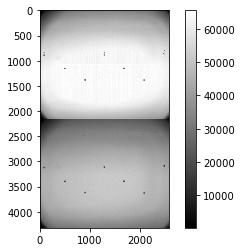

In [23]:
im16 = cv2.imread(paths.tmp_dir+'/DIF/dif_images/focus/+0/2017-09-29_09.22.41/DispenserOpt_00004_2017-09-29_09.22.50.png',cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
imgplot =plt.imshow(im16, cmap='gray')
plt.colorbar()
#util.plot_imgs([(im16, 'IRef')], max_cols = 2)


### From DIF_ImageProcessor.readAndCropImages

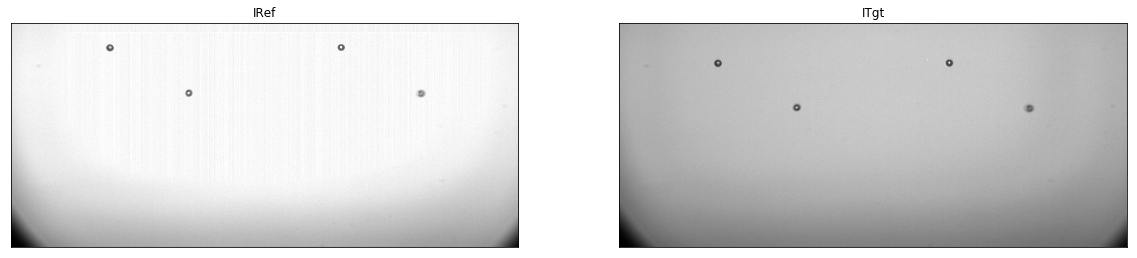

In [53]:
#im16 = cv2.imread('../images/DispenserOpt_00097_2016-10-31_14.03.19.png', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# First make 2D by slicing out one channel
if len(im16.shape) == 3:
    im16 = im16[:,:,1]

# if 16bit, convert to 8bit
if im16.dtype.name.find('16') >= 0:
    im8 = bu.convert16BitTo8Bit(im16)
else:
    im8 = im16

# now subimage into ref and tgt
if (im8.shape[0] == 2*frameHeight_px):
    ITgt = im8[frameHeight_px+rMin:frameHeight_px+rMax:rStep,cMin:cMax:cStep]

IRef = im8[rMin:rMax:rStep,cMin:cMax:cStep]
IRef16 = im16[rMin:rMax:rStep,cMin:cMax:cStep]

util.plot_imgs([(IRef, 'IRef'), (ITgt, 'ITgt')], max_cols = 2)

### Preprocess and find blobs in Ref image

In [58]:
def simplePreProcAndBinarize(img):
    gauBlur1 = cv2.GaussianBlur(img,(3,3),0)
    gauBlur2 = cv2.GaussianBlur(img,(11,11),0)
    diffOfGau = gauBlur1-gauBlur2
    dog_med = cv2.medianBlur(diffOfGau, 5, 0)
    ret, im_thresh = cv2.threshold(dog_med,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    util.plot_imgs([(img, 'img'), (gauBlur1, 'gauBlur1'),(gauBlur2, 'gauBlur2'),(diffOfGau, 'diffOfGau'),(dog_med, 'dog_med'),(im_thresh, 'im_thresh')], max_cols = 2)
    return im_thresh


There are 160 region properties found:


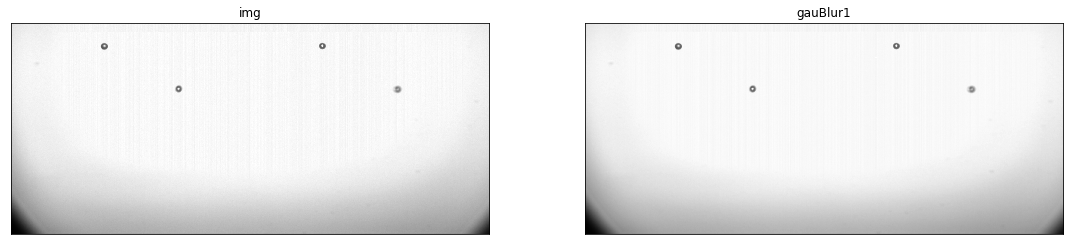

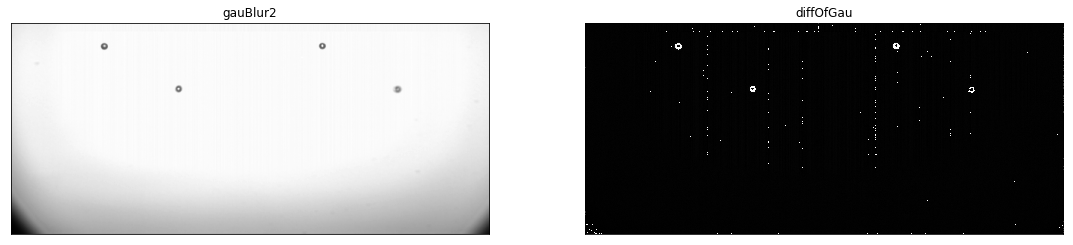

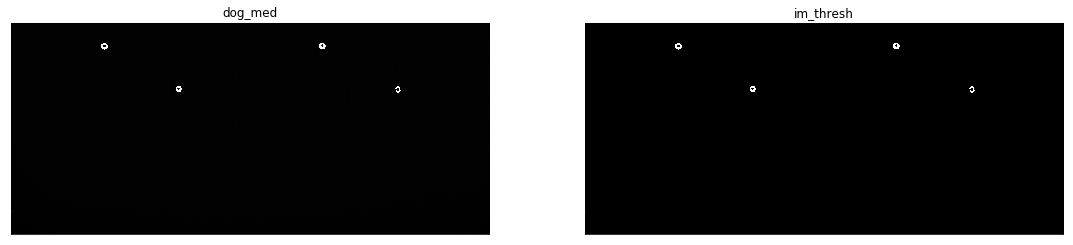

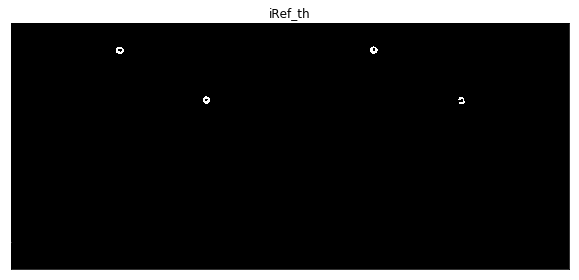

In [61]:
# Ref image processing
#---------------------
# Preprocess and binarize reference image
#iRef_th = bu.preprocAndBinarizeImg(iRef, blurKernelSize, tophatKernalSize, minThVal, maxThVal, thresholdType)
#iRef_th = bu.simplePreProcAndBinarize(IRef16)
iRef_th = simplePreProcAndBinarize(IRef)

# Find, label and size up the blobs
labelArrRef = measure.label(iRef_th)

# Measure properties of labeled image regions.
#  http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
RegPropsRef = measure.regionprops(labelArrRef)

numBlobsRef = len(RegPropsRef)
print("There are %d region properties found:" % (numBlobsRef))
      
# for i in range(numBlobsRef):
#     print(RegPropsRef[i].centroid)

blobCentroidsRef = np.array([RegPropsRef[i].centroid for i in range(numBlobsRef)])

util.plot_imgs([(iRef_th, 'iRef_th')], max_cols = 2)

### What did we find? Filter out according to circTh, minSzInPx, maxSzInPx

In [30]:
# Blob centroids after particle filter
FiltIdxRef, numGoodBlobsRef = bu.pruneBlobs(RegPropsRef, circTh, minSzInPx, maxSzInPx)
print("numGoodBlobsRef: %d" % (numGoodBlobsRef))

numGoodBlobsRef: 8


In [28]:
# Good blob indices are 0:numGoodBlobs-1 and bad blob indices numGoodBlobs+1:-1
FiltIdxRef = FiltIdxRef[0:numGoodBlobsRef]

blobCentFiltRef = blobCentroidsRef[FiltIdxRef[0:numGoodBlobsRef]]
RegPropsRefFilt = [RegPropsRef[i] for i in FiltIdxRef[0:numGoodBlobsRef]]

print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsRef), len(RegPropsRefFilt)))


# of Initial ref blobs = 24, # blobs after pruning = 8


### Now process the Target image...

# of Initial ref blobs = 20, # blobs after pruning = 8


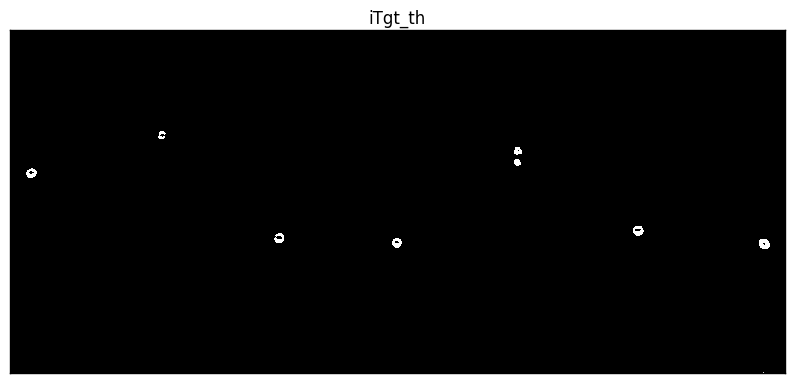

In [33]:
iTgt_th = bu.simplePreProcAndBinarize(ITgt)
labelArrTgt = measure.label(iTgt_th)
RegPropsTgt = measure.regionprops(labelArrTgt)
numBlobsTgt = len(RegPropsTgt)
blobCentroidsTgt = np.array([RegPropsTgt[i].centroid for i in range(numBlobsTgt)])
FiltIdxTgt, numGoodBlobsTgt = bu.pruneBlobs(RegPropsTgt, circTh, minSzInPx, maxSzInPx)
FiltIdxTgt = FiltIdxTgt[0:numGoodBlobsTgt]
blobCentFiltTgt = blobCentroidsTgt[FiltIdxTgt[0:numGoodBlobsTgt]]
RegPropsTgtFilt = [RegPropsTgt[i] for i in FiltIdxTgt[0:numGoodBlobsTgt]]
print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsTgt), len(RegPropsTgtFilt)))
util.plot_imgs([(iTgt_th, 'iTgt_th')], max_cols = 2)